In [12]:
import sys
import os

cur_dir = os.path.dirname(os.path.abspath(''))
sys.path.append(cur_dir)

from tools.utils import reload_module
from datasets.fabric import make_sigmod_ds, DatasetName
from tools.utils import set_seed
import numpy as np

set_seed(1234)

In [19]:
dataset_name = DatasetName.RADIOML_2016
dataset_path = os.path.abspath(cur_dir + "/data/radioml_2016/RML2016.10a_dict.pkl")
radioml_ds = make_sigmod_ds(dataset_name)
radioml_ds.load(dataset_path)
splitted_radioml_ds = radioml_ds.split_train_val_test(0.8, 0.1)

In [3]:
from models.fabric import make_sigmod_model, Convolution01xConfiguration, ModelName

cnn_v1_configuration = Convolution01xConfiguration(
    input_shape=(128, 2),
    n_classes=len(radioml_ds.get_modulations()),
    output_channels=[32, 48, 64, 96, 128, 192],
    kernel_sizes=[8, 8, 8, 8, 8, 8],
    paddings=["same", "same", "same", "same", "same", "same"],
    max_pool_sizes=[1, 1, 2, 1, 2, 1],
    max_pool_strides=[1, 1, 2, 1, 2, 1],
    avg_size=32,
    dense_sizes=[],
)

model = make_sigmod_model(ModelName.CNN_1D_V012, cnn_v1_configuration)

# model.summary()

2023-07-02 21:54:53.102517: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-02 21:54:53.119235: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-02 21:54:53.119363: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [4]:
import tensorflow as tf

def step_decay(epoch):
    lrate = 0.001
    factor = epoch // 8
    lrate /= 10**factor
    return lrate


lrate = tf.keras.callbacks.LearningRateScheduler(step_decay)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"],
)

N_EPOCHS = 16
BATCH_SIZE = 256

h = model.fit(
    splitted_radioml_ds.train.data,
    splitted_radioml_ds.train.labels,
    epochs=N_EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(splitted_radioml_ds.val.data, splitted_radioml_ds.val.labels),
    callbacks=[lrate]
)


Epoch 1/16


2023-07-02 21:54:55.361542: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-07-02 21:54:56.302966: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-07-02 21:54:56.305057: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7ff2df2b7d20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-07-02 21:54:56.305070: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Ti Laptop GPU, Compute Capability 8.6
2023-07-02 21:54:56.307650: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-07-02 21:54:56.390226: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lif

688/688 [==============================] - 13s 13ms/step - loss: 1.7724 - accuracy: 0.3374 - val_loss: 1.5343 - val_accuracy: 0.4332 - lr: 0.0010
Epoch 2/16
688/688 [==============================] - 8s 12ms/step - loss: 1.4224 - accuracy: 0.4613 - val_loss: 1.3037 - val_accuracy: 0.5022 - lr: 0.0010
Epoch 3/16
688/688 [==============================] - 8s 12ms/step - loss: 1.2520 - accuracy: 0.5236 - val_loss: 1.2265 - val_accuracy: 0.5352 - lr: 0.0010
Epoch 4/16
688/688 [==============================] - 8s 12ms/step - loss: 1.1957 - accuracy: 0.5486 - val_loss: 1.1952 - val_accuracy: 0.5531 - lr: 0.0010
Epoch 5/16
688/688 [==============================] - 8s 12ms/step - loss: 1.1685 - accuracy: 0.5574 - val_loss: 1.1773 - val_accuracy: 0.5555 - lr: 0.0010
Epoch 6/16
688/688 [==============================] - 8s 12ms/step - loss: 1.1513 - accuracy: 0.5625 - val_loss: 1.1506 - val_accuracy: 0.5656 - lr: 0.0010
Epoch 7/16
688/688 [==============================] - 8s 12ms/step - loss:

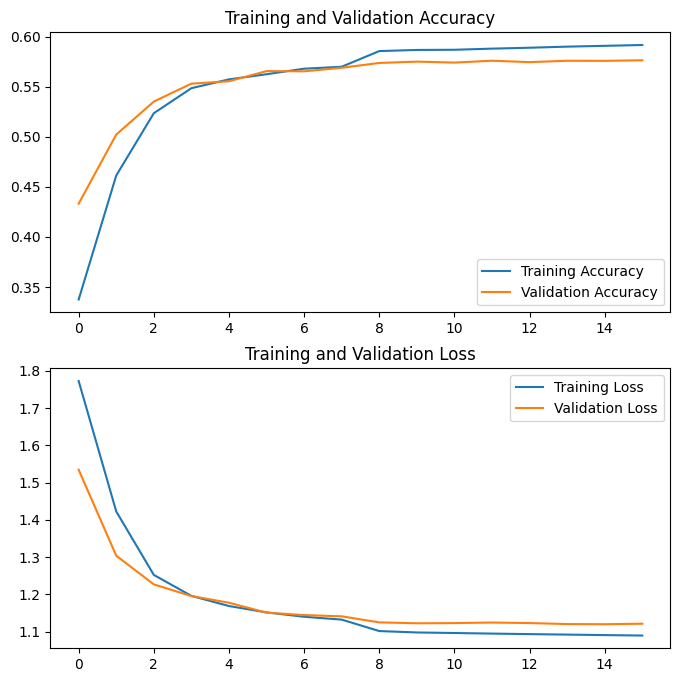

In [5]:
from evaluation.metric_evaluation import metric_evaluation, snr_to_metric_evaluation
from evaluation.vizualization import plot_train, plot_snr_to_acc
plot_train(h.history)

688/688 [==============================] - 1s 2ms/step
Overall test accuracy: {'Overall': 0.5773636363636364}
8PSK test accuracy: 0.5467289719626168
AM-DSB test accuracy: 0.6830845771144278
AM-SSB test accuracy: 0.891642371234208
BPSK test accuracy: 0.6099903938520653
CPFSK test accuracy: 0.6239006725297465
GFSK test accuracy: 0.6572560673600792
PAM4 test accuracy: 0.6828528072837633
QAM16 test accuracy: 0.32850723914128804
QAM64 test accuracy: 0.5127947817360763
QPSK test accuracy: 0.5371604305484367
WBFM test accuracy: 0.2734375
Confusion matrix:
[[1053   16  575   31   42   35   22   52   28   63    9]
 [   0 1373  431    6    8   39    5    5    0    6  137]
 [  18   50 1835   21   28   41   19    4    0    5   37]
 [  25   19  600 1270   20   14   91   17    2   16    8]
 [  34   22  546   13 1206   35   22   13    8   17   17]
 [   7   41  518   10   26 1327    8    5    0    7   70]
 [  15   16  448   62   21   18 1350   18    7   11   11]
 [  86   11  354   28   39   28   20  6

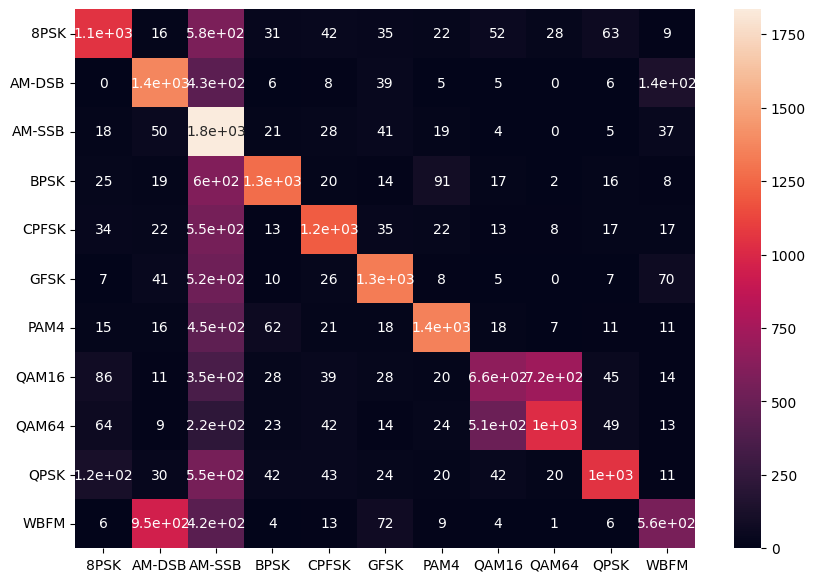

688/688 [==============================] - 1s 2ms/step
Overall test accuracy: {'Overall': 0.5764090909090909}
8PSK test accuracy: 0.5597054182009469
AM-DSB test accuracy: 0.679474216380182
AM-SSB test accuracy: 0.8825012607160867
BPSK test accuracy: 0.6140973630831643
CPFSK test accuracy: 0.6299709020368575
GFSK test accuracy: 0.6590909090909091
PAM4 test accuracy: 0.7017969888295289
QAM16 test accuracy: 0.332657200811359
QAM64 test accuracy: 0.4822456813819578
QPSK test accuracy: 0.5366098294884654
WBFM test accuracy: 0.2640198511166253
Confusion matrix:
[[1064   16  581   19   51   26   20   35   19   56   14]
 [   4 1344  416    9    7   36    9    3    0    3  147]
 [  16   54 1750   26   23   41   24    5    1    8   35]
 [  32   23  567 1211   15   28   52   18    3   13   10]
 [  31   29  572   13 1299   45   22   17    4   12   18]
 [   6   42  512    7   21 1305    7    4    1    3   72]
 [  21   28  412   76   20   13 1445   18    7    9   10]
 [  93   20  391   27   45   19 

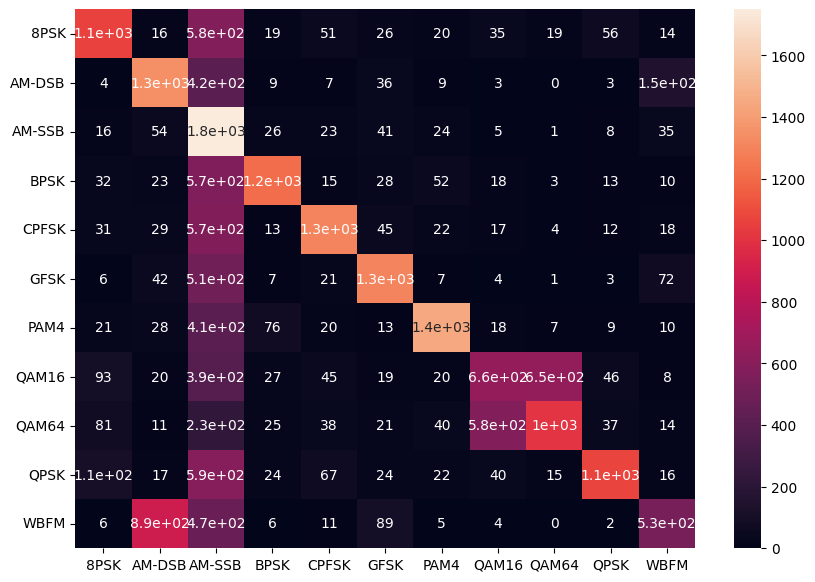

In [20]:
cm_test, cls_to_acc_test = metric_evaluation(
    model,
    splitted_radioml_ds.test.data,
    splitted_radioml_ds.test.labels,
    radioml_ds.get_modulations(),
)

cm_val, cls_to_acc_val = metric_evaluation(
    model,
    splitted_radioml_ds.val.data,
    splitted_radioml_ds.val.labels,
    radioml_ds.get_modulations(),
)

SNR: -20 -- Overall test accuracy: 0.10886742756804214
SNR: -18 -- Overall test accuracy: 0.0967741935483871
SNR: -16 -- Overall test accuracy: 0.1018867924528302
SNR: -14 -- Overall test accuracy: 0.10678733031674208
SNR: -12 -- Overall test accuracy: 0.16589861751152074
SNR: -10 -- Overall test accuracy: 0.23730378578024008
SNR: -8 -- Overall test accuracy: 0.3670774647887324
SNR: -6 -- Overall test accuracy: 0.5199628597957289
SNR: -4 -- Overall test accuracy: 0.6429840142095915
SNR: -2 -- Overall test accuracy: 0.7588028169014085
SNR: 0 -- Overall test accuracy: 0.8005514705882353
SNR: 2 -- Overall test accuracy: 0.843065693430657
SNR: 4 -- Overall test accuracy: 0.8437209302325581
SNR: 6 -- Overall test accuracy: 0.8512911843276937
SNR: 8 -- Overall test accuracy: 0.8600182982616651
SNR: 10 -- Overall test accuracy: 0.8489010989010989
SNR: 12 -- Overall test accuracy: 0.8523550724637681
SNR: 14 -- Overall test accuracy: 0.8606921029281278
SNR: 16 -- Overall test accuracy: 0.833491

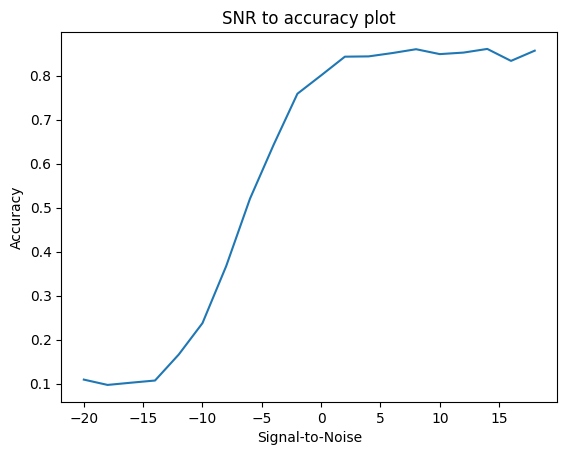

In [21]:
snr_to_acc_test = snr_to_metric_evaluation(
    model,
    splitted_radioml_ds.test.data,
    splitted_radioml_ds.test.labels,
    radioml_ds.get_snrs()[radioml_ds.get_split_indecies().test],
)
snr_to_acc_val = snr_to_metric_evaluation(
    model,
    splitted_radioml_ds.val.data,
    splitted_radioml_ds.val.labels,
    radioml_ds.get_snrs()[radioml_ds.get_split_indecies().val],
)
plot_snr_to_acc(snr_to_acc_test)

In [22]:
reload_module("evaluation.results_serialization")
from evaluation.results_serialization import dump_results

from copy import deepcopy

history = deepcopy(h.history)
history["lr"] = list(map(lambda x: float(x), history["lr"]))

dump_results(
    "cnn_test_results/",
    model=model,
    model_config=cnn_v1_configuration,
    model_name=ModelName.CNN_1D_V012,
    dataset_name=DatasetName.RADIOML_2016,
    dataset_path=dataset_path,
    train_history=history,
    cm_test=cm_test,
    cls_to_acc_test=cls_to_acc_test,
    snr_to_acc_test=snr_to_acc_test,
    cm_val=cm_val,
    cls_to_acc_val=cls_to_acc_val,
    snr_to_acc_val=snr_to_acc_val,
    dump_model=True,
)

HHHI


In [9]:
reload_module("evaluation.results_serialization")
from evaluation.results_serialization import load_results
from pprint import pprint
results = load_results("cnn_test_results/", load_model=True)

pprint(results)
print(results["model"])

{'cls_to_acc_test': {'8PSK': 0.5467289719626168,
                     'AM-DSB': 0.6830845771144278,
                     'AM-SSB': 0.891642371234208,
                     'BPSK': 0.6099903938520653,
                     'CPFSK': 0.6239006725297465,
                     'GFSK': 0.6572560673600792,
                     'Overall': 0.5773636363636364,
                     'PAM4': 0.6828528072837633,
                     'QAM16': 0.32850723914128804,
                     'QAM64': 0.5127947817360763,
                     'QPSK': 0.5371604305484367,
                     'WBFM': 0.2734375},
 'cm_test': [[1053, 16, 575, 31, 42, 35, 22, 52, 28, 63, 9],
             [0, 1373, 431, 6, 8, 39, 5, 5, 0, 6, 137],
             [18, 50, 1835, 21, 28, 41, 19, 4, 0, 5, 37],
             [25, 19, 600, 1270, 20, 14, 91, 17, 2, 16, 8],
             [34, 22, 546, 13, 1206, 35, 22, 13, 8, 17, 17],
             [7, 41, 518, 10, 26, 1327, 8, 5, 0, 7, 70],
             [15, 16, 448, 62, 21, 18, 1350, 18, 7, 11, 1

In [10]:
snr_to_acc_test = snr_to_metric_evaluation(
    results["model"],
    splitted_radioml_ds.test.data,
    splitted_radioml_ds.test.labels,
    radioml_ds.get_snrs()[radioml_ds.get_split_indecies().test],
)


SNR: -20 -- Overall test accuracy: 0.10886742756804214
SNR: -18 -- Overall test accuracy: 0.0967741935483871
SNR: -16 -- Overall test accuracy: 0.1018867924528302
SNR: -14 -- Overall test accuracy: 0.10678733031674208
SNR: -12 -- Overall test accuracy: 0.16589861751152074
SNR: -10 -- Overall test accuracy: 0.23730378578024008
SNR: -8 -- Overall test accuracy: 0.3670774647887324
SNR: -6 -- Overall test accuracy: 0.5199628597957289
SNR: -4 -- Overall test accuracy: 0.6429840142095915
SNR: -2 -- Overall test accuracy: 0.7588028169014085
SNR: 0 -- Overall test accuracy: 0.8005514705882353
SNR: 2 -- Overall test accuracy: 0.843065693430657
SNR: 4 -- Overall test accuracy: 0.8437209302325581
SNR: 6 -- Overall test accuracy: 0.8512911843276937
SNR: 8 -- Overall test accuracy: 0.8600182982616651
SNR: 10 -- Overall test accuracy: 0.8489010989010989
SNR: 12 -- Overall test accuracy: 0.8523550724637681
SNR: 14 -- Overall test accuracy: 0.8606921029281278
SNR: 16 -- Overall test accuracy: 0.833491